# Aprendizaje Automático - Intermedio

## Cross validation

### Introducción

En este tutorial aprenderemos cómo usar la **validación cruzada** para medir mejor la ejecución del modelo.

El aprendizaje automático es un proceso iterativo. Te enfrentarás a elecciones sobre qué variables predictivas usar, qué tipos de modelos usar, qué argumentos proporcionar a esos modelos, etc. Hasta ahora, has tomado estas decisiones de una manera basada en datos midiendo la calidad del modelo con un conjunto de validación (o reserva).

Pero hay algunos inconvenientes en este enfoque. Para entender esto imagina que tienes un conjunto de datos con 5000 filas. Por lo general, mantendrás aproximadamente el 20% de los datos como un conjunto de datos de validación, ó 1000 filas. Pero esto deja alguna posibilidad aleatoria de determinar las puntuaciones del modelo. Es decir, un modelo podría funcionar bien en un conjunto de 1000 filas, incluso si fuera incorrecto en 1000 filas diferentes.

En el extremo, puedes imaginar tener solo 1 fila de datos en el conjunto de validación. Si comparas modelos alternativos, ¡cuál de ellos hace las mejores predicciones en un solo punto de datos será sobre todo una cuestión de suerte!

En general, cuanto mayor sea el conjunto de validación, menor aleatoriedad (también conocido como "ruido") hay en nuestra medida de calidad del modelo y más confiable será. Desafortunadamente, solo podemos obtener un conjunto de validación grande eliminando filas de nuestros datos de entrenamiento y los conjuntos de datos de entrenamiento más pequeños significan modelos peores.

### ¿Qué es la validación cruzada?

En la **validación cruzada** o *cross-validation*, ejecutamos nuestro proceso de modelado en diferentes subconjuntos de datos para obtener múltiples medidas de calidad del modelo.

Por ejemplo, podríamos comenzar dividiendo los datos en 5 partes, cada una de ella correspondiente al 20% del conjunto de datos completo. En este caso, decimos que hemos dividido los datos en 5 "**folds**".

![cross_validation](./images/cross_validation.png)

Luego, ejecutamos un experimento para cada fold:

+ En el **Experimento 1**, usamos el primer fold como un conjunto de validación (o reserva) y todo lo demás como datos de entrenamiento. Esto nos da una medida de la calidad del modelo basada en un conjunto de reserva del 20%.
+ En el **Experimento 2**, conservamos los datos del segundo fold (y usamos todo excepto el segundo fold para entrenar el modelo). El conjunto de reserva se utiliza para obtener una segunda estimación de la calidad del modelo.
+ Repetimos este proceso, usando cada fold una vez como conjunto de reserva. En conjunto, el 100% de los datos se usan como reserva en algún momento y terminamos con una medida de la calidad del modelo que se basa en todas las filas del conjunto de datos (incluso si no usamos todas las filas simultáneamente).

### ¿Cuándo debemos usar la validación cruzada?

La validación cruzada proporciona una medida más precisa de la calidad del modelo, lo cual es especialmente importante si estamos tomando muchas decisiones de modelado. Sin embargo, puede llevar más tiempo ejecutarlo, ya que estima varios modelos (uno para cada fold).

Entonces, dadas estas contrapartidas, ¿cuándo deberíamos usar cada enfoque?

+ Para *conjuntos de datos pequeños*, donde la carga computacional adicional no es un gran problema, debemos ejecutar la validación cruzada.
+ Para *conjuntos de datos más grandes*, un solo conjunto de validación es suficiente. Nuestro código se ejecutará más rápido y es posible que tengamos suficientes datos para que haya poca necesidad de reutilizar algunos de ellos para reservarlos.

No existe un umbral simple para lo que constituye un conjunto de datos grande versus pequeño. Pero si el modelo tarda unos minutos o menos en ejecutarse, probablemente valga la pena cambiar a validación cruzada.

Alternativamente, se puede ejecutar la validación cruzada y ver si las puntuaciones para cada experimento parecen cercanas. Si cada experimento produce los mismos resultados, un solo conjunto de validación es probablemente suficiente.

### Ejemplo

In [5]:
import pandas as pd

# Lee los datos
data = pd.read_csv('./input/melbourne-housing-snapshot/melb_data.csv')

# Selecciona el subconjunto de predictores
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Selecciona el objetivo
y = data.Price

Luego, definimos un pipeline que utiliza un imputador para completar los valores ausentes y un modelo de random forest para hacer predicciones.

Si bien es posible hacer una validación cruzada sin pipelines, ¡es bastante difícil! El uso de un pipeline hará que el código sea notablemente sencillo.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

Obtenemos las puntuaciones de validación cruzada con la función `cross_val_score()` de scikit-learn. Establecemos el número de folds con el parámetro `cv`.

In [9]:
from sklearn.model_selection import cross_val_score

# Multiplicamos por -1 ya que sklearn calcula MAE negativos
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Puntuación MAE:\n", scores)

Puntuación MAE:
 [301628.7893587  303164.4782723  287298.331666   236061.84754543
 260383.45111427]


El parámetro `scoring` elige una medida de la calidad del modelo a usar: en este caso, elegimos el error absoluto medio negativo (MAE). Los documentos de scikit-learn muestran una [lista de opciones](https://scikit-learn.org/stable/modules/model_evaluation.html).

Es un poco sorprendente que especifiquemos MAE negativo. Scikit-learn tiene una convención en la que se definen todas las métricas para que un número alto sea mejor. El uso de negativos aquí les permite ser consistentes con esa convención, aunque el MAE negativo es casi desconocido en otros lugares.

Generalmente, queremos una sola medida de la calidad del modelo para comparar modelos alternativos. Entonces tomamos el promedio de todas los experimentos.

In [10]:
print("Puntuación media MAE (a través de los experimentos):")
print(scores.mean())

Puntuación media MAE (a través de los experimentos):
277707.3795913405


### Conclusión
El uso de la validación cruzada produce una medida mucho mejor de la calidad del modelo, con el beneficio adicional de hacer nuestro código más limpio: ten en cuenta que ya no necesitamos seguir la pista de conjuntos de entrenamiento y validación separados. Entonces, especialmente para conjuntos de datos pequeños, ¡es una buena mejora!

### Ejercicio

En este ejercicio, aprovecharremos lo que aprendido para ajustar un modelo de aprendizaje automático con **validación cruzada**. Trabajaremos con datos de [Housing Prices Competition for Kaggle Learn Users](https://www.kaggle.com/c/home-data-for-ml-course). 

![Ames Housing dataset image](https://i.imgur.com/lTJVG4e.png)

Vamos a cargar los conjuntos de entrenamiento y validación en `X_train`, `X_valid`, `y_train`, e `y_valid`.  El conjunto de pruebas es cargado en `X_test`.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# lee los datos
train_data = pd.read_csv('./input/train.csv', index_col='Id')
test_data = pd.read_csv('./input/test.csv', index_col='Id')

# elimina columnas con objetivos ausentes, separa objetivo de predictores
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice              
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Selecciona solo las columnas numéricas
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

In [2]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


Hasta ahora, hemos aprendido a construir pipelines con scikit-learn. Por ejemplo, el siguiente pipeline usará [`SimpleImputer()`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) para reemplazar los valores ausentes en los datos, antes de usar [`RandomForestRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) para entrenar un modelo de random forest para hacer predicciones. Establecemos el número de árboles en el modelo de random forest con el parámetro `n_estimators`, y establecer `random_state` asegura la reproducibilidad.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

También aprendimos a usar pipelines en la validación cruzada. El siguiente código utiliza la función [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) para obtener el error absoluto medio (MAE), promediado a partir de cinco folds diferentes. Recordemos que establecemos el número de pliegues con el parámetro `cv`.

In [5]:
from sklearn.model_selection import cross_val_score

# Multiplicamos por -1 ya que sklearn calcula MAE negativos
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("Puntuación media MAE:", scores.mean())

Puntuación media MAE: 18276.410356164386


#### Paso 1: Escribe una función útil

En este ejercicio, utilizaremos la validación cruzada para seleccionar parámetros para un modelo de aprendizaje automático.

Comienza escribiendo una función `get_score()` que informe el MAE promedio (en tres folds de validación cruzada) de un pipeline de aprendizaje automático que utiliza:
- los datos en `X` e `y` para crear folds,
- `SimpleImputer()` (con todos los parámetros dejados por defecto) para reemplazar los valores faltantes, y
- `RandomForestRegressor()` (con `random_state = 0`) para ajustar un modelo de bosque aleatorio.

El parámetro `n_estimators` suministrado a `get_score()` se usa al establecer el número de árboles en el modelo de random forest.

In [6]:
def get_score(n_estimators):
    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X, y,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')
    return scores.mean()


#### Paso 2: Prueba diferentes valores de parámetros

Ahora, utilizarás la función definida en el Paso 1 para evaluar el rendimiento del modelo correspondiente a ocho valores diferentes para el número de árboles en el random forest: 50, 100, 150, ..., 300, 350, 400.

Almacena sus resultados en un diccionario de Python `results`, donde `results [i]` es el MAE promedio devuelto por `get_scores (i)`.

In [7]:
results = {}
for i in range(1,9):
    results[50*i] = get_score(50*i)

#### Paso 3: Encuentra el mejor valor de parámetro

Vamos a visualizar los resultados del Paso 2.

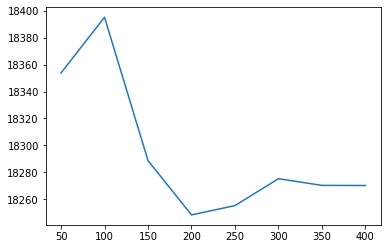

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

Dados los resultados, ¿qué valor de `n_estimators` parece mejor para el modelo de random forest?

In [18]:
n_estimators_best = 200

En este ejercicio, has explorado un método para elegir los parámetros apropiados en un modelo de aprendizaje automático.

Si deseas obtener más información sobre [optimización de hiperparámetros](https://en.wikipedia.org/wiki/Hyperparameter_optimization), recomendamos que comiences con **grid search**, que es un método sencillo para determinar la mejor combinación de parámetros para un modelo de aprendizaje automático. Afortunadamente, scikit-learn también contiene una función incorporada [`GridSearchCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) que puede hacer el código de grid search muy eficiente.